In [1]:
from lightgbm import LGBMRegressor

**（1）XGBoost的缺点**
在LightGBM提出之前，最有名的GBDT工具就是XGBoost了，它是基于预排序方法的决策树算法。这种构建决策树的算法基本思想是：**首先，对所有特征都按照特征的数值进行预排序。其次，在遍历分割点的时候用 的代价找到一个特征上的最好分割点。最后，在找到一个特征的最好分割点后，将数据分裂成左右子节点。**

这样的预排序算法的优点是能精确地找到分割点。但是缺点也很明显：首先，空间消耗大。这样的算法需要保存数据的特征值，还保存了特征排序的结果（例如，为了后续快速的计算分割点，保存了排序后的索引），这就需要消耗训练数据两倍的内存。其次，时间上也有较大的开销，在遍历每一个分割点的时候，都需要进行分裂增益的计算，消耗的代价大。最后，对cache优化不友好。在预排序后，特征对梯度的访问是一种随机访问，并且不同的特征访问的顺序不一样，无法对cache进行优化。同时，在每一层长树的时候，需要随机访问一个行索引到叶子索引的数组，并且不同特征访问的顺序也不一样，也会造成较大的cache miss。

**（2）LightGBM的优化**
为了避免上述XGBoost的缺陷，并且能够在不损害准确率的条件下加快GBDT模型的训练速度，lightGBM在传统的GBDT算法上进行了如下优化：

基于Histogram的决策树算法。
单边梯度采样 Gradient-based One-Side Sampling(GOSS)：使用GOSS可以减少大量只具有小梯度的数据实例，这样在计算信息增益的时候只利用剩下的具有高梯度的数据就可以了，相比XGBoost遍历所有特征值节省了不少时间和空间上的开销。
互斥特征捆绑 Exclusive Feature Bundling(EFB)：使用EFB可以将许多互斥的特征绑定为一个特征，这样达到了降维的目的。
带深度限制的Leaf-wise的叶子生长策略：大多数GBDT工具使用低效的按层生长 (level-wise) 的决策树生长策略，因为它不加区分的对待同一层的叶子，带来了很多没必要的开销。实际上很多叶子的分裂增益较低，没必要进行搜索和分裂。LightGBM使用了带有深度限制的按叶子生长 (leaf-wise) 算法。
直接支持类别特征(Categorical Feature)
支持高效并行
Cache命中率优化

## Histogram的决策树算法

### （1）直方图结构
Histogram algorithm应该翻译为直方图算法，直方图算法的基本思想是：
先把连续的浮点特征值离散化成k个整数，同时构造一个宽度为k的直方图。在遍历数据的时候，根据离散化后的值作为索引在直方图中累积统计量，当遍历一次数据后，直方图累积了需要的统计量，然后根据直方图的离散值，遍历寻找最优的分割点。
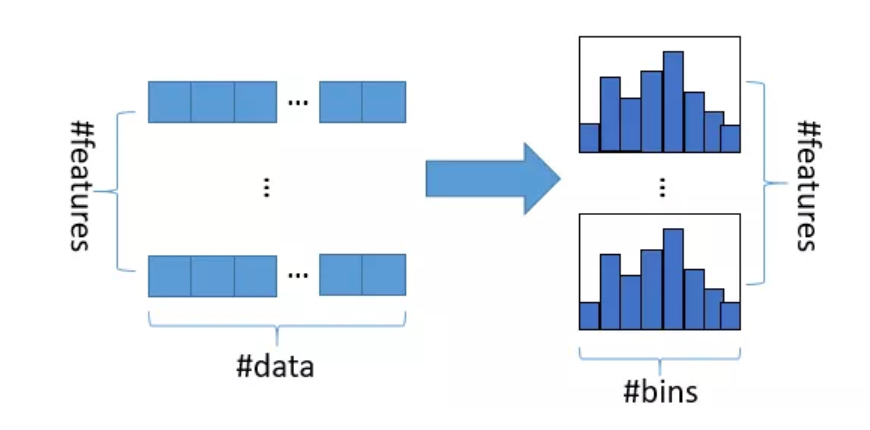

**使用直方图的优点：**
首先，最明显就是**内存消耗的降低**，直方图算法不仅不需要额外存储预排序的结果，而且可以只保存特征离散化后的值，而这个值一般用 8 位整型存储就足够了，内存消耗可以降低为原来的1/8。
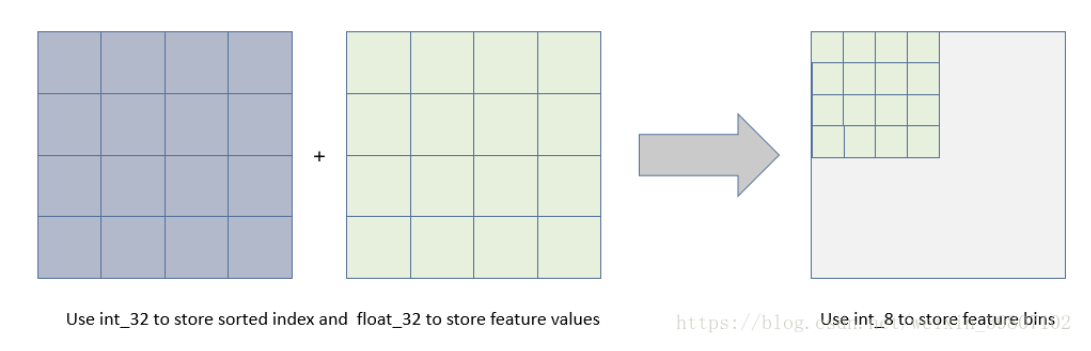

然后在**计算上的代价也大幅降低**，预排序算法每遍历一个特征值就需要计算一次分裂的增益，而直方图算法只需要计算k次（k可以认为是常数），时间复杂度从O(#data#feature)优化到O(k#features)。

当然，Histogram 算法并不是完美的。由于特征被离散化后，**找到的并不是很精确的分割点**，所以会对结果产生影响。但在不同的数据集上的结果表明，离散化的分割点对最终的精度影响并不是很大，甚至有时候会更好一点。

## （2）带深度限制的leaf-wise的叶子生长策略

在 Histogram 算法之上，LightGBM 进行进一步的优化。

首先它抛弃了大多数 GBDT 工具使用的按层生长 (level-wise) 的决策树生长策略，而使用了带有深度限制的按叶子生长 (leaf-wise) 算法。Level-wise 过一次数据可以同时分裂同一层的叶子，容易进行多线程优化，也好控制模型复杂度，不容易过拟合。但实际上 Level-wise 是一种低效的算法，因为它不加区分的对待同一层的叶子，带来了很多没必要的开销，因为实际上很多叶子的分裂增益较低，没必要进行搜索和分裂。

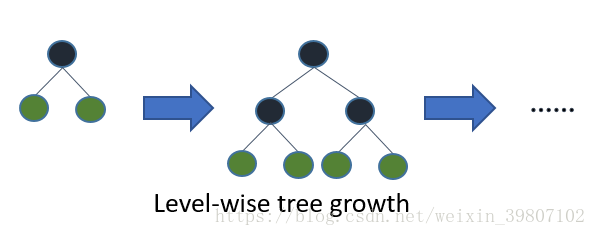

 Leaf-wise 则是一种更为高效的策略，每次从当前所有叶子中，找到分裂增益最大的一个叶子，然后分裂，如此循环。因此同 Level-wise 相比，在分裂次数相同的情况下，Leaf-wise 可以降低更多的误差，得到更好的精度。Leaf-wise 的缺点是可能会长出比较深的决策树，产生过拟合。因此 **LightGBM 在 Leaf-wise 之上增加了一个最大深度的限制，在保证高效率的同时防止过拟合。**
 
 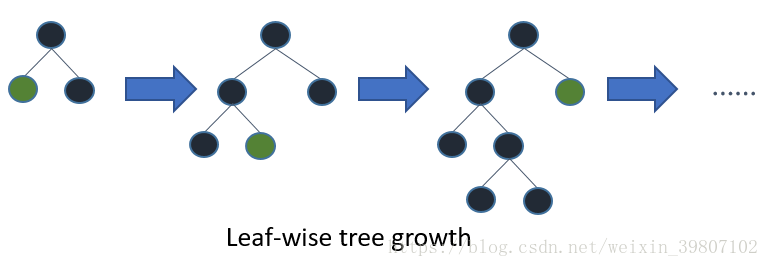
 
 

## （3）直方图加速

**LightGBM 另一个优化是 Histogram（直方图）做差加速。**
一个容易观察到的现象：一个叶子的直方图可以由它的父亲节点的直方图与它兄弟的直方图做差得到。通常构造直方图，需要遍历该叶子上的所有数据，但直方图做差仅需遍历直方图的k个桶。利用这个方法，LightGBM 可以在构造一个叶子的直方图后，可以用非常微小的代价得到它兄弟叶子的直方图，在速度上可以提升一倍。
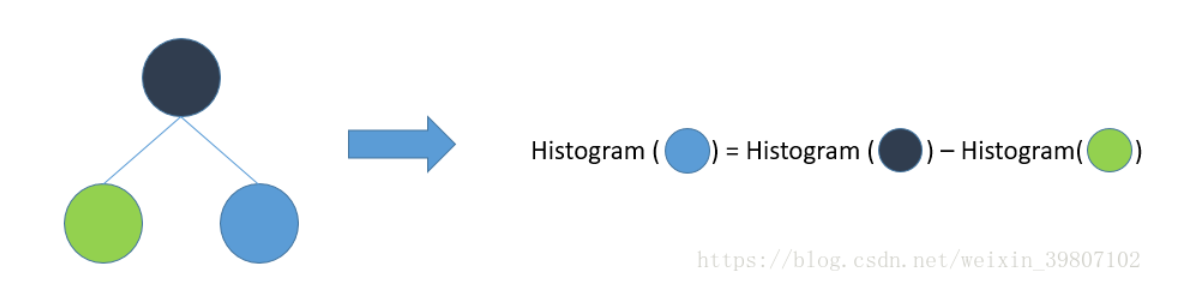